In [1]:
import sys; sys.path.append('..'); from wwa import *

In [2]:
df = pd.read_csv("triggers.csv", index_col = "ID")
df["date"] = [datetime(r.year, r.month, 1) for k, r in df.iterrows()]

In [3]:
df_floods = df.loc[(df.hazard == "Flood") & (df.SoE_only == 0)]

<AxesSubplot: xlabel='year'>

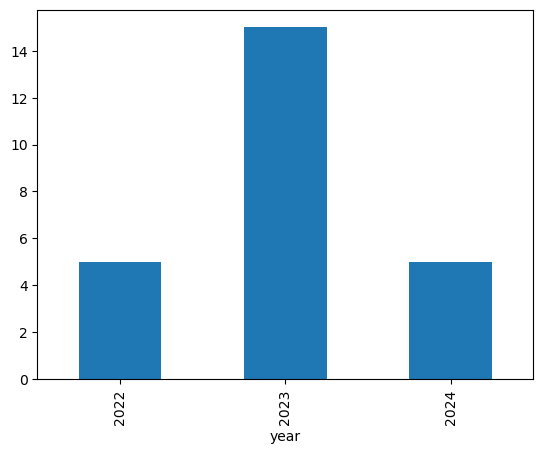

In [4]:
df_floods.loc[df_floods.month.isin([9,10,11])].groupby("year").count().hazard.plot(kind = "bar")

# EMDat

## Floods

In [185]:
df = pd.read_excel("public_emdat_custom_request_2024-12-03_7ec927c6-9c64-4b38-9f4d-187d8aa3b845.xlsx", index_col = "DisNo.")
df = df.loc[df["Disaster Type"] == "Flood", 
            ["Country", "Subregion", "Region", "End Year", "End Month", "Total Deaths", "No. Injured", "No. Affected", "No. Homeless" ]]

Text(0, 0.5, 'Number of flood events')

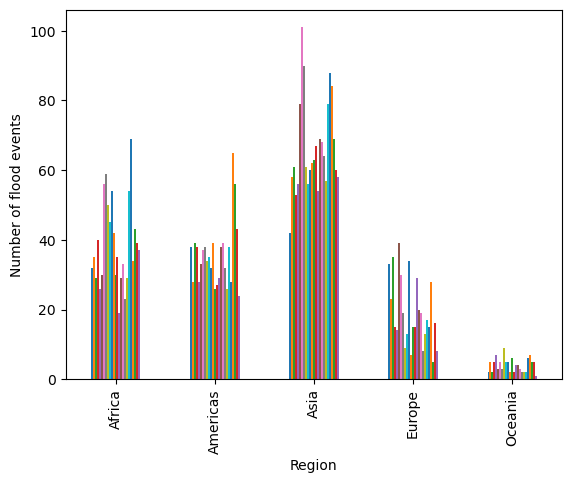

In [186]:
# number of floods in EMdat
pd.crosstab(df["End Year"], columns = df["Region"]).transpose().plot(kind = "bar", legend = False)
plt.gca().set_ylabel("Number of flood events")

Text(0, 0.5, 'Number of fatalities')

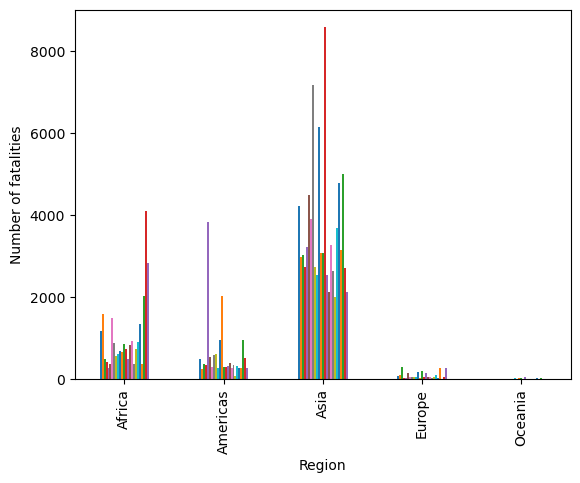

In [187]:
pd.crosstab(df["End Year"], columns = df["Region"], values = df["Total Deaths"], aggfunc = sum).transpose().plot(kind = "bar", legend = False)
plt.gca().set_ylabel("Number of fatalities")

## Fires

In [59]:
df = pd.read_excel("public_emdat_custom_request_2024-12-03_7ec927c6-9c64-4b38-9f4d-187d8aa3b845.xlsx", index_col = "DisNo.")
df = df.loc[df["Disaster Type"] == "Wildfire", 
            ["Country", "Subregion", "Region", "End Year", "End Month", "Total Deaths", "No. Injured", "No. Affected", "No. Homeless" ]]

Text(0.5, 1.0, 'Number of fatalities')

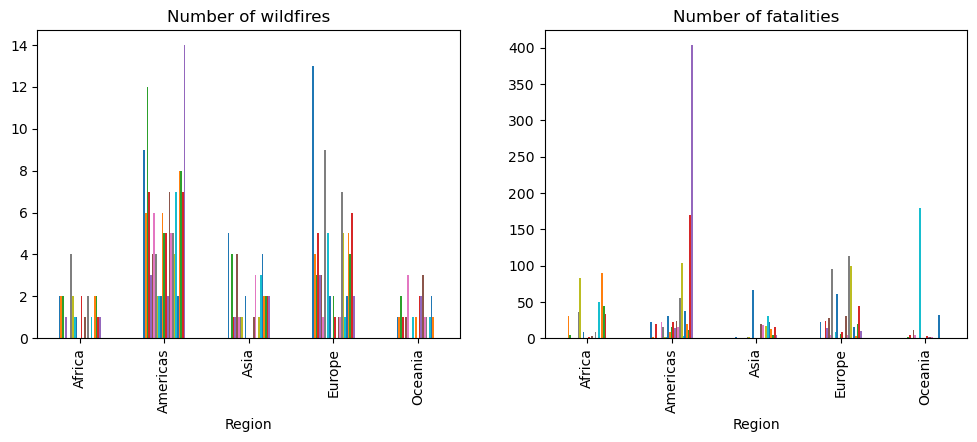

In [74]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

ax = axs[0]
pd.crosstab(df["End Year"], columns = df["Region"]).transpose().plot(ax = ax, kind = "bar", legend = False)
ax.set_title("Number of wildfires")

ax = axs[1]
pd.crosstab(df["End Year"], columns = df["Region"], values = df["Total Deaths"], aggfunc = sum).transpose().plot(ax = ax, kind = "bar", legend = False)
ax.set_title("Number of fatalities")

In [78]:
df_am = df.loc[(df.Region == "Americas") & (df["Total Deaths"] > 0)]
df_am.sort_values("Total Deaths")

,Country,Subregion,Region,End Year,End Month,Total Deaths,No. Injured,No. Affected,No. Homeless
DisNo.,,,,,,,,,
2012-0542-USA,United States of America,Northern America,Americas,2012,8.0,1.0,NaN,1809.0,NaN
2001-0303-USA,United States of America,Northern America,Americas,2001,4.0,1.0,10.0,129.0,NaN
2001-0722-USA,United States of America,Northern America,Americas,2001,10.0,1.0,NaN,NaN,NaN
2003-0369-CAN,Canada,Northern America,Americas,2003,9.0,1.0,NaN,NaN,NaN
2024-0524-CAN,Canada,Northern America,Americas,2024,8.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-0441-USA,United States of America,Northern America,Americas,2020,10.0,32.0,NaN,NaN,NaN
2017-0434-USA,United States of America,Northern America,Americas,2017,12.0,43.0,185.0,NaN,9000.0
2018-0409-USA,United States of America,Northern America,Americas,2018,12.0,88.0,NaN,250000.0,NaN


Text(0.5, 1.0, 'Number of fatalities')

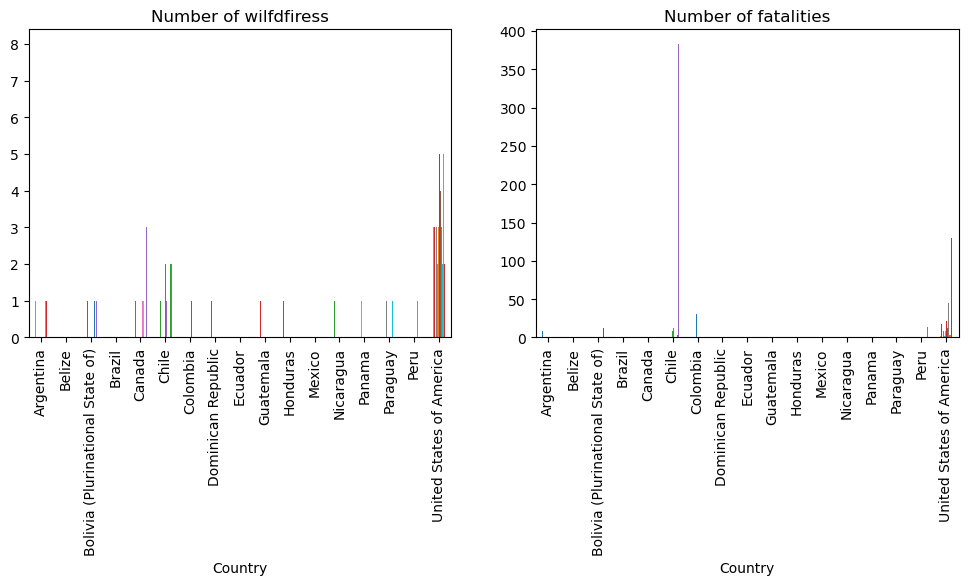

In [75]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

ax = axs[0]
pd.crosstab(df_am["End Year"], columns = df_am["Country"]).transpose().plot(ax = ax, kind = "bar", legend = False)
ax.set_title("Number of wilfdfiress")

ax = axs[1]
pd.crosstab(df_am["End Year"], columns = df_am["Country"], values = df_am["Total Deaths"], aggfunc = sum).transpose().plot(ax = ax, kind = "bar", legend = False)
ax.set_title("Number of fatalities")

# Map of rx5day compared to climatology

In [3]:
pr = wrap_lon(decode_times(xr.open_dataset("data/era5_prcp_daily_1_max_30_5v.nc", decode_times = False)).max_tp)
pr = pr.where(regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(pr) == 0)
pr = pr.where(pr.lat > -60)

In [4]:
pr_2024 = pr.sel(time = "2024").squeeze(drop = True)

## Percentiles

In [19]:
quantiles = np.arange(0.1,1,0.1)
pr_qq = pr.sel(time = slice("1991","2020")).quantile(quantiles, dim = "time")
pr_qq = xr.concat([xr.zeros_like(pr_2024).where(~np.isnan(pr_2024)).expand_dims(quantile = [0]),
                   pr_qq,
                   pr.max("time").expand_dims(quantile = [1])], "quantile").rename(quantile = "qq")

cat_labels = [str(int(q1*100))+"-"+str(int(q2*100))+"%" for q1,q2 in zip(pr_qq.qq[:-1].values, pr_qq.qq[1:].values)]
cats = [np.logical_and(pr_2024 > pr_qq.sel(qq = q1), pr_2024 <= pr_qq.sel(qq = q2)) for q1,q2 in zip(pr_qq.qq[:-1].values, pr_qq.qq[1:].values)]
pr_cat = xr.concat([cats[i]*(i+1) for i in range(len(cats))], "new").sum("new")
pr_cat = pr_cat.where(pr_cat > 0)

In [72]:
pr_cat.to_netcdf("data/rx5day-percentiles.nc")

In [81]:
(pr.sel(time = "2024") > pr.sel(time = slice("1991","2020")).max("time")).sum()

<xarray.DataArray 'max_tp' ()>
array(3741)
Attributes:
    long_name:     annual maximum of 5-daily Precipitation
    units:         mm/dy
    cell_methods:  annual maximum of 5-daily data

In [82]:
(pr_cat == 10).sum()

<xarray.DataArray 'max_tp' ()>
array(10990)
Attributes:
    long_name:     annual maximum of 5-daily Precipitation
    units:         mm/dy
    cell_methods:  annual maximum of 5-daily data

Text(0, 0.5, 'Proportion of land surface')

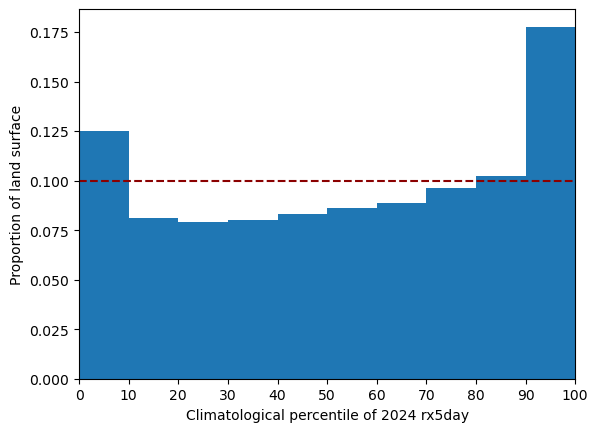

In [20]:
plt.hist(pr_cat.stack(xy = ["lat", "lon"]), bins = np.arange(0.5,11.5,1), density = True)
# plt.xticks(ticks = [x+1.5 for x in range(len(quantiles)+1)], labels = cat_labels)
plt.xticks(ticks = np.arange(0.5,11,1), labels = np.arange(0,11,1)*10)

plt.axhline(y = 0.1, color = "darkred", ls = "--")
plt.margins(x = 0)
plt.xlabel("Climatological percentile of 2024 rx5day")
plt.ylabel("Proportion of land surface")

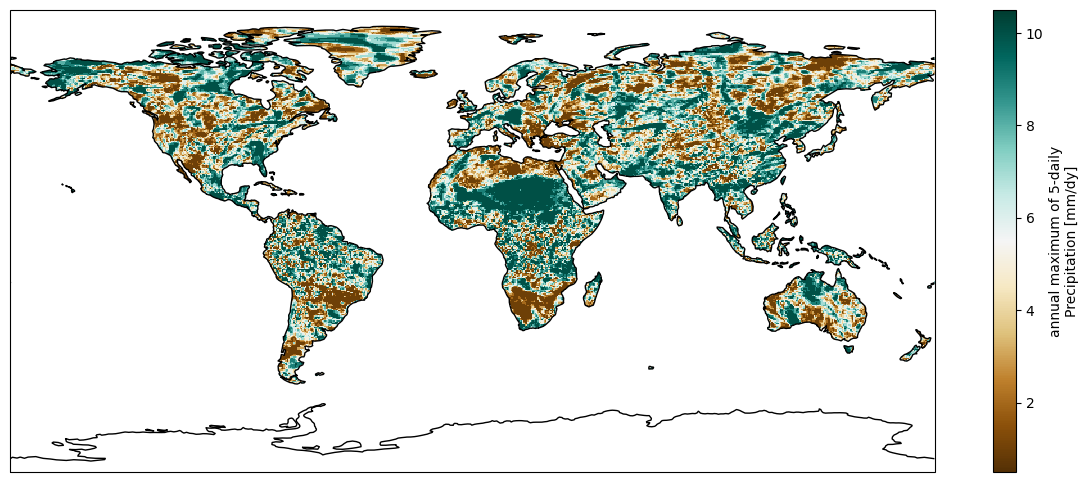

In [60]:
fig, ax = plt.subplots(figsize = (15,6), subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
cbar = pr_cat.plot(ax = ax, cmap = "BrBG", vmin = 0.5, vmax = 10.5)
ax.coastlines()

Text(0.5, 1.0, 'Percentile of 2024 with respect to 1991-2020 climatology')

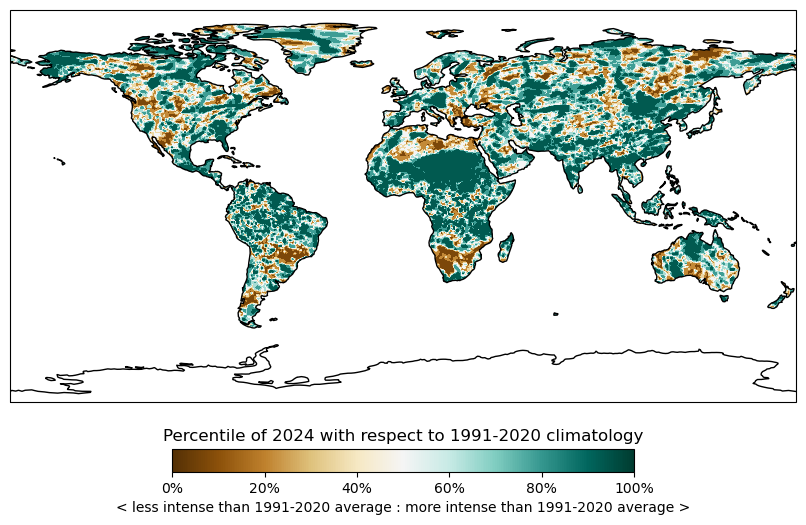

In [69]:
fig, ax = plt.subplots(figsize = (15,6), subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
ax.contourf(pr_cat.lon, pr_cat.lat, pr_cat, cmap = "BrBG")
ax.coastlines()

cbar2 = plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.1, 
                     label = "< less intense than 1991-2020 average : more intense than 1991-2020 average >")
cbar2.ax.set_xticks(ticks = np.arange(0.5,11.5,2), labels = [str(v*10)+"%" for v in range(0,11,2)])
cbar2.ax.set_title('Percentile of 2024 with respect to 1991-2020 climatology')

## Ranks

In [5]:
ranks = xr.concat([pr.sel(time = slice("1991","2020")).rank("time")] + [xr.concat([pr.sel(time = slice("1991","2020")), pr.sel(time = str(y))], "time").rank("time").sel(time = str(y)) for y in [2021,2022,2023,2024]], "time")

In [47]:
ranks_flattened = ranks.stack(xy = ["lat", "lon"]).dropna("xy", "all")

In [6]:
rank_cmap = matplotlib.cm.get_cmap('BrBG'); rank_cmap.set_over('darkblue'); rank_cmap.set_under('gold')

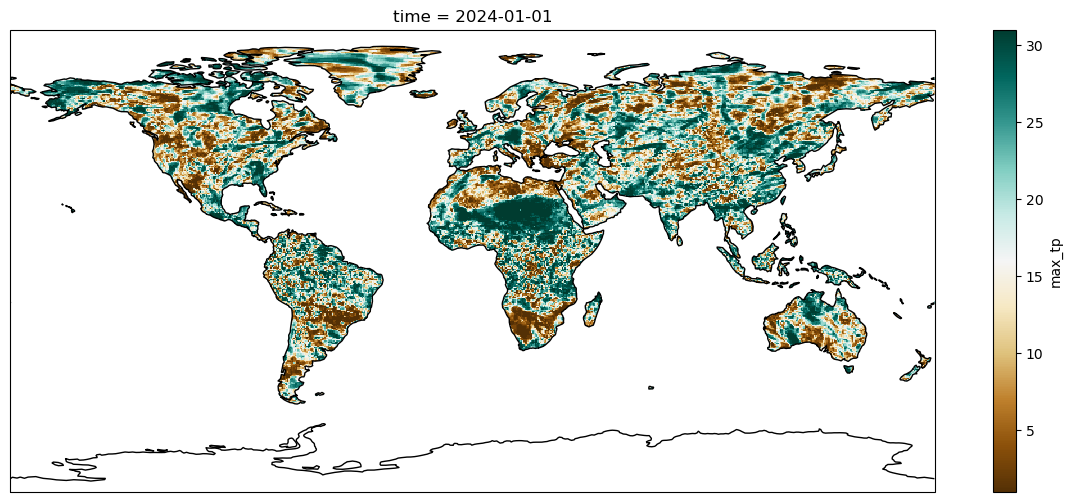

In [32]:
fig, ax = plt.subplots(figsize = (15,6), subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
cbar = ranks.sel(time = "2024").plot(ax = ax, vmin = 1, vmax = 31, cmap = "BrBG")
ax.coastlines()

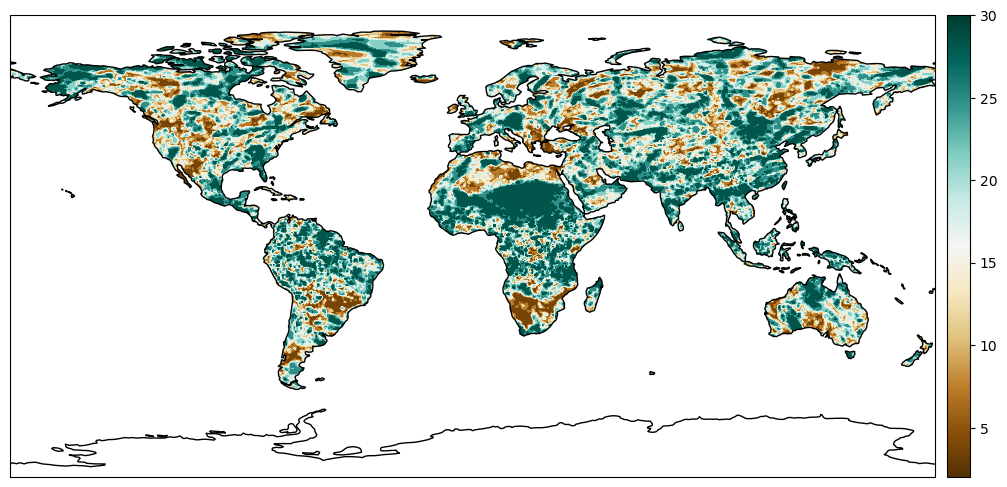

In [17]:
fig, ax = plt.subplots(figsize = (15,6), subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
ax.contourf(ranks.lon, ranks.lat, ranks.sel(time = "2024").squeeze(drop = True), cmap = "BrBG")
ax.coastlines()
ax.set_title("")
plt.colorbar(cbar, ax = ax, pad = 0.01)

Text(0, 0.5, 'Proportion of land surface')

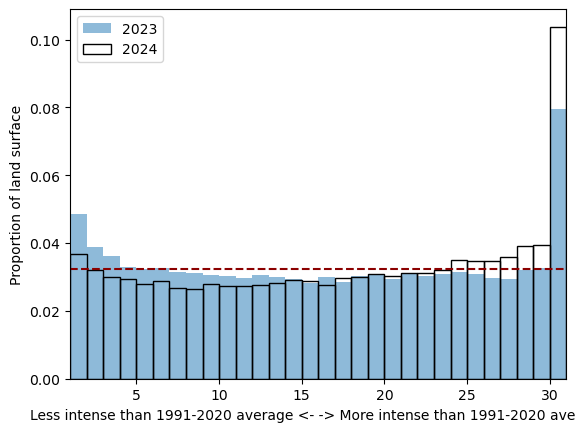

In [84]:
plt.hist(ranks_flattened.sel(time = "2023").squeeze(drop = True), density = True, bins = range(32)[1:], alpha = 0.5, label = "2023")
plt.hist(ranks_flattened.sel(time = "2024").squeeze(drop = True), density = True, bins = range(1,32), edgecolor = "k", facecolor = "none", label = "2024")

plt.axhline(y = 1/31, color = "darkred", ls = "--")
plt.margins(x = 0)
plt.xlabel("Less intense than 1991-2020 average <- -> More intense than 1991-2020 average")
plt.legend()
plt.ylabel("Proportion of land surface")

# CAMS emissions

In [ ]:
# load & compile daily data
ds = xr.open_mfdataset("cams_frp/*.nc").frpfire.rename(valid_time = "time")
ds_m = ds.resample(time = "MS").sum()
ds_m.to_netcdf("cams_frp_monthly.nc")

In [ ]:
ds = xr.open_dataset("cams_frp_monthly.nc").frpfire

In [ ]:
ts = ds.sum(["latitude", "longitude"])

In [ ]:
ts.plot()

# ALARMES

In [2]:
pantanal = pd.read_csv("PANTANAL_accumulated_20240101_20241204.csv", sep = ",", skiprows = 5, index_col = 0) / 1e6
amazon = pd.read_csv("AMAZÔNIA_accumulated_20240101_20241205.csv", sep = ",", skiprows = 5, index_col = 0) / 1e6

In [12]:
def plot_ba(y, ax, **kwargs):
    
    ts_y = ba.loc[[str(y)]].transpose().iloc[:-1]
    ts_y.index = [datetime(y,int(d[-2:]),int(d[:2])) for d in ts_y.index]
    ax.plot(ts_y.index.dayofyear, ts_y, **kwargs)
    
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

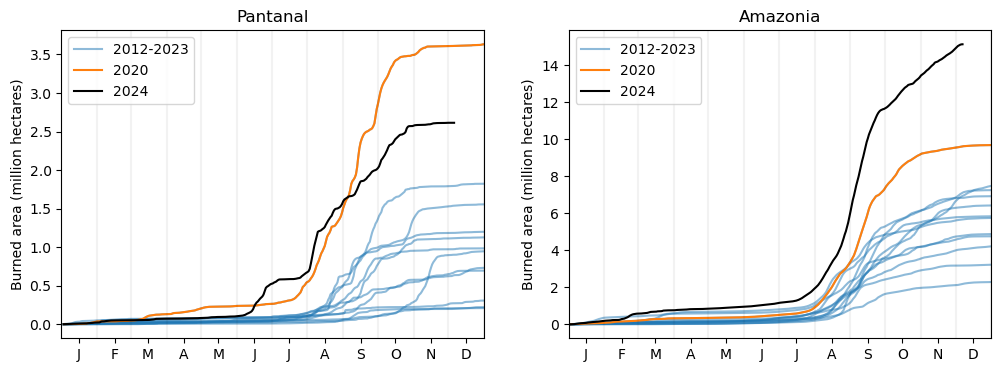

In [14]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)
plt.subplots_adjust(wspace = 0.2)

for i in range(2):
    
    ax = axs[i]
    ba = [pantanal, amazon][i]
    plot_ba(2012, ax = ax, color = "tab:blue", alpha = 0.5, label = "2012-2023")
    for y in range(2013,2024): plot_ba(y, ax = ax, color = "tab:blue", alpha = 0.5, label = "_")
    plot_ba(2020, ax = ax, color = "tab:orange", label = "2020")
    plot_ba(2024, ax = ax, color = "k", label = "2024")

    ax.set_ylabel("Burned area (million hectares)")
    ax.legend()
    ax.set_title(["Pantanal", "Amazonia"][i])
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    ax.set_xlim(0,366)

    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]